In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = r"C:\Users\HP\age_detection\dataset"

# Image dimensions
IMG_SIZE = 100

# Lists to store data and labels
data = []
labels = []

# Load and process images
for img_name in os.listdir(dataset_path):
    try:
        # Extract age from filename (e.g., 25_1_0.jpg)
        age = int(img_name.split("_")[0])
        
        # Load image
        img_path = os.path.join(dataset_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0  # Normalize to [0, 1]

        data.append(image)
        labels.append(age)

    except Exception as e:
        print(f"Skipping file {img_name} due to error: {e}")

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

print(f"Total samples: {len(X)}")


Total samples: 9779


In [2]:
# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 7823
Testing samples: 1956


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Input shape (same as your resized image)
input_shape = (100, 100, 3)

# Load MobileNetV2 base (without the top layers)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model weights

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)  # Age prediction is a regression task

# Combine
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


C:\Users\HP\AppData\Local\Temp\ipykernel_20056\2364176890.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 50, 50, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 50, 50, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 50, 50, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 50, 50, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 50, 50, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 50, 50, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 50, 50, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 50, 50, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 50, 50, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 50, 50, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 50, 50, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 51, 51, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 25, 25, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# Save model to this file
checkpoint = ModelCheckpoint("age_model.h5", monitor='val_mae', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)


In [5]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 406.7696 - mae: 15.2814
Epoch 1: val_mae improved from inf to 10.59232, saving model to age_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - loss: 406.2176 - mae: 15.2692 - val_loss: 228.3700 - val_mae: 10.5923
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 191.0729 - mae: 10.0088
Epoch 2: val_mae improved from 10.59232 to 9.49029, saving model to age_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 191.0190 - mae: 10.0073 - val_loss: 180.5776 - val_mae: 9.4903
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 161.2218 - mae: 9.0276
Epoch 3: val_mae improved from 9.49029 to 9.29236, saving model to age_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - loss: 161.1919 - mae: 9.0267 - val_loss: 182.6999 - val_mae: 9.2924
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 143.0106 - mae: 8.4735
Epoch 4: val_mae did not improve from 9.29236
245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 143.0084 - mae: 8.4735 - val_loss: 181.4827 - val_mae: 9.4176
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 134.3343 - mae: 8.0987
Epoch 5: val_mae improved from 9.29236 to 9.02340, saving model to age_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - loss: 134.3202 - mae: 8.0985 - val_loss: 183.6467 - val_mae: 9.0234
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 117.3099 - mae: 7.6511
Epoch 6: val_mae improved from 9.02340 to 8.62865, saving model to age_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 117.3157 - mae: 7.6513 - val_loss: 159.2629 - val_mae: 8.6287
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 112.2049 - mae: 7.4377
Epoch 7: val_mae did not improve from 8.62865
245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 112.2178 - mae: 7.4383 - val_loss: 178.8637 - val_mae: 8.8827
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 98.5879 - mae: 6.9944
Epoch 8: val_mae did not improve from 8.62865
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - loss: 98.6070 - mae: 6.9950 - val_loss: 159.9347 - val_mae: 8.7227
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 96.9258 - mae: 6.8384
Epoch 9: val_mae did not improve from 8.62865
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - loss: 96.9358 - mae: 6.8391 - val_loss: 170.1760 - val_mae: 8.8558


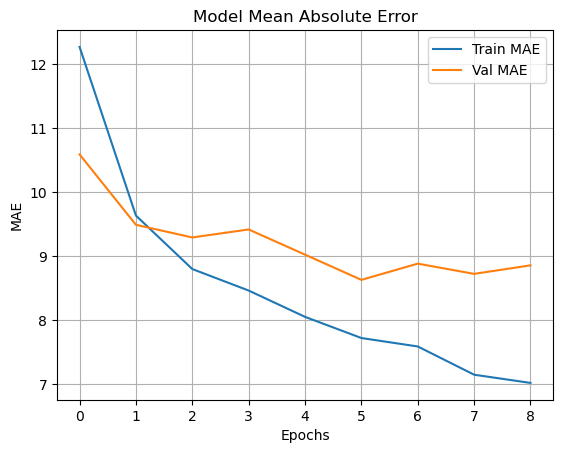

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Predict the ages
y_pred = model.predict(X_test).flatten().astype(int)
y_true = y_test.astype(int)

# Step 2: Convert predicted and actual ages to age groups
def to_age_group(age):
    if age < 10:
        return "0-9"
    elif age < 20:
        return "10-19"
    elif age < 30:
        return "20-29"
    elif age < 40:
        return "30-39"
    elif age < 50:
        return "40-49"
    elif age < 60:
        return "50-59"
    elif age < 70:
        return "60-69"
    else:
        return "70+"

y_pred_grouped = [to_age_group(age) for age in y_pred]
y_true_grouped = [to_age_group(age) for age in y_true]


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step


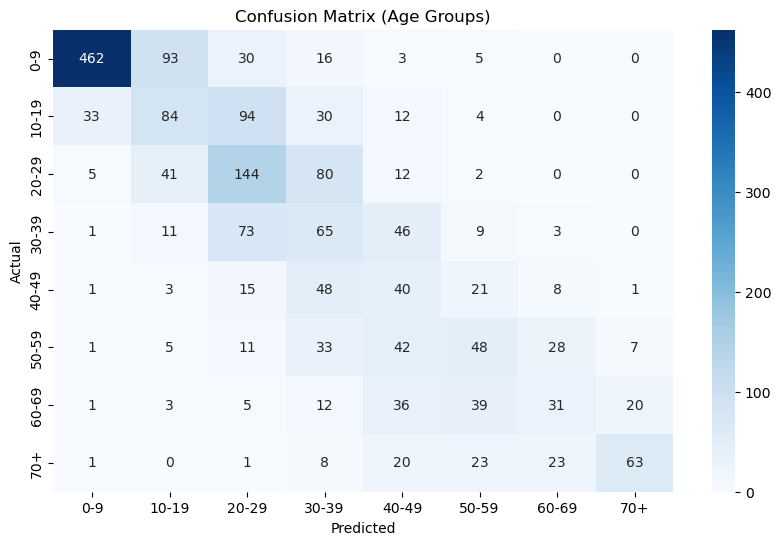

In [8]:
# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true_grouped, y_pred_grouped)
labels = sorted(list(set(y_true_grouped + y_pred_grouped)))

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Age Groups)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
# Step 4: Print classification report
print("Classification Report:")
print(classification_report(y_true_grouped, y_pred_grouped))


Classification Report:
              precision    recall  f1-score   support

         0-9       0.91      0.76      0.83       609
       10-19       0.35      0.33      0.34       257
       20-29       0.39      0.51      0.44       284
       30-39       0.22      0.31      0.26       208
       40-49       0.19      0.29      0.23       137
       50-59       0.32      0.27      0.29       175
       60-69       0.33      0.21      0.26       147
         70+       0.69      0.45      0.55       139

    accuracy                           0.48      1956
   macro avg       0.43      0.39      0.40      1956
weighted avg       0.53      0.48      0.49      1956

